## Public Infrastructure in Argentina (Regional Analysis)

### 1. Data Wrangling

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn.preprocessing as skp
import scipy.stats as stats

#Importing datasets
df_path = r"Cleaned_data\dataset_infrastructure.csv"
shape_path = r"Cleaned_data\provinces.shp"
df_original = pd.read_csv(df_path)
shape_original = gpd.read_file(shape_path)

In [2]:
#Data rearranging & translating
print(df_original.columns)
df = df_original[["idproyecto", "fechainicioanio", "fechafinanio", "sectornombre", "montototal","nombreprovincia", "duracionobrasdias", "etapaobra"]]
df.columns = ["project_id", "year_start", "year_finish", "sector", "total_amount", "province", "duration_days", "status"]

#This Function transaltes the sector column to english
def sector_translation(x):
    sectors = list(df.sector.unique())
    if x == sectors[0]:
        x = "Water and Sewer"
    elif x == sectors[1]:
        x = "Roadworks"
    elif x == sectors[2]:
        x = "Others"
    elif x == sectors[3]:
        x = "Healthcare"
    elif x == sectors[4]:
        x = "Architecture"
    elif x == sectors[5]:
        x = "Education"
    elif x == sectors[6]:
        x = "Urban Equipment"
    elif x == sectors[7]:
        x = "Housing"
    elif x == sectors[8]:
        x = "Water resources"
    return x
df.sector = df.sector.apply(sector_translation)

#This function translates the status column to english
def status_translation(x):
    status = list(df.status.unique())
    if x == status[0]:
        x = "Finished"
    elif x == status[1]:
        x = "In progress"
    elif x == status[2]:
        x = "Other"
    return x 
df.status = df.status.apply(status_translation)

#This function adds a new column that classifies each province by region (See more about regions on report)
df.province = df.province.str.lower()
def region_classifier(x):
    provinces = list(df.province.unique())
    ba_region = provinces[0:2]
    patagonia_region = provinces[2:3]+provinces[8:9]+provinces[11:12]+provinces[18:20]+provinces[22:23]
    north_region = provinces[3:4]+ provinces[6:7]+provinces[10:11]+provinces[12:14]+provinces[15:16]+provinces[20:22]+provinces[23:24]
    central_region = provinces[4:6]+provinces[7:8]
    cuyo_region = provinces[9:10]+provinces[14:15]+provinces[16:17]+provinces[17:18]

    if x in ba_region:
        x = "Buenos Aires"
    elif x in patagonia_region:
        x = "Patagonia"
    elif x in north_region:
        x = "Great North"
    elif x in central_region:
        x = "Central Region"
    elif x in cuyo_region:
        x = "New Cuyo Region"
    return x
df["region"] = df.province.apply(region_classifier)
df.project_id = df.project_id.astype("category")

Index(['idproyecto', 'numeroobra', 'codigobapin', 'fechainicioanio',
       'fechafinanio', 'nombreobra', 'descripicionfisica', 'montototal',
       'sectornombre', 'avancefinanciero', 'avancefisico',
       'entidadejecutoranombre', 'duracionobrasdias', 'objetivogeneral',
       'tipoproyecto', 'nombredepto', 'nombreprovincia', 'codigo_bahra',
       'etapaobra', 'tipomoneda', 'url_perfil_obra',
       'programa_infraestructura', 'organismo_financiador_1',
       'organismo_financiador_2', 'organismo_financiador_prestamo',
       'contraparte_key', 'contraparte_val', 'contraparte_cuit',
       'contraparte_modalidad', 'tag_accionclimatica', 'tag_ods_incidencia'],
      dtype='object')


C:\Users\angel\AppData\Local\Temp\ipykernel_13148\4116735773.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sector = df.sector.apply(sector_translation)
C:\Users\angel\AppData\Local\Temp\ipykernel_13148\4116735773.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.status = df.status.apply(status_translation)
C:\Users\angel\AppData\Local\Temp\ipykernel_13148\4116735773.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [3]:
#Shape File Arranging
shape = shape_original
shape["NAM"] = shape["NAM"].str.lower()
shape.loc[shape["NAM"] == "tierra del fuego, antártida e islas del atlántico sur", "NAM"] = 'tierra del fuego antártida e islas del atlántico'

#This function classifies provinces by region on the shape file
def shape_region_classifier(x):
    ba_region = ['ciudad autónoma de buenos aires', "buenos aires"]
    patagonia_region = ['neuquén', 'la pampa', "tierra del fuego antártida e islas del atlántico", 'santa cruz', 'chubut' , 'río negro' ]
    north_region = ['catamarca', 'tucumán' ,'jujuy' ,'chaco', 'formosa', 'santiago del estero', 'corrientes', 'misiones' ,'salta']
    cuyo_region = ['mendoza', 'san luis', 'san juan', 'la rioja']
    central_region = ['córdoba', 'santa fe', 'entre ríos']
    if x in ba_region:
        x = "Buenos Aires"
    elif x in patagonia_region:
        x = "Patagonia"
    elif x in cuyo_region:
        x = "New Cuyo Region"
    elif x in north_region:
        x = "Great North"
    elif x in central_region:
        x = "Central Region"
    return x 

shape["region"] = shape["NAM"].apply(shape_region_classifier)
shape_region = shape.dissolve(by="region", aggfunc="sum")

## Data Analysis

### 2. Projects Distribution

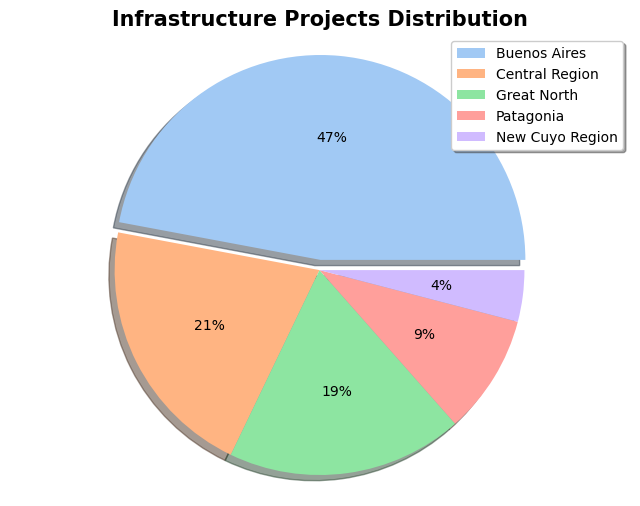

Number of Projects by Region
region
Buenos Aires       3279
Central Region     1451
Great North        1299
Patagonia           657
New Cuyo Region     283
Name: count, dtype: int64

Projct Distribution by Region
region
Buenos Aires       0.470512
Central Region     0.208208
Great North        0.186397
Patagonia          0.094275
New Cuyo Region    0.040608
Name: proportion, dtype: float64


<Figure size 640x480 with 0 Axes>

In [4]:
### Investigate the projects distribution by region
regions = ["Buenos Aires", "Central Region", "Great North", "Patagonia", "New Cuyo Region"]
explode = (0.05, 0, 0,0,0)
plt.figure(figsize=(8,6))
plt.pie(df.region.value_counts(), explode=explode, autopct='%.f%%', colors=sns.color_palette("pastel"), shadow=True)
plt.axis("equal")
plt.legend(labels=regions, shadow=True)
plt.title("Infrastructure Projects Distribution", fontsize=15, fontweight="bold")
plt.show()
plt.clf()


print("Number of Projects by Region")
print(df.region.value_counts())
print("")
print("Projct Distribution by Region")
print(df.region.value_counts(normalize=True))


Text(0.5, 1.0, 'Number of projects per region')

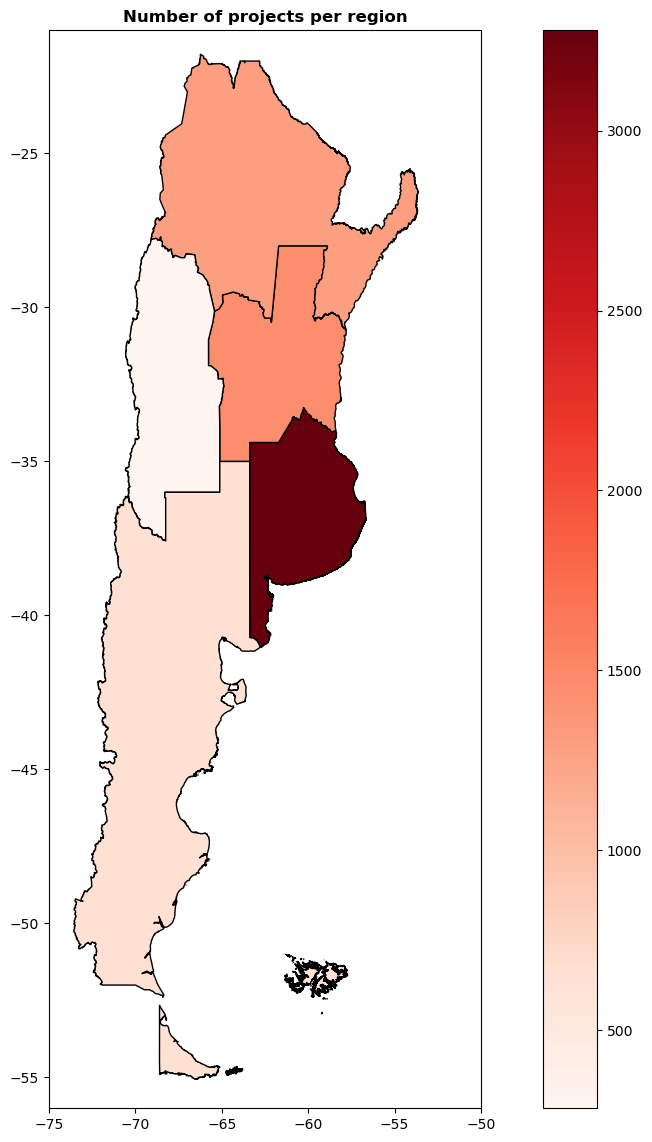

In [5]:
#Visualizing the distribution on a map 
df_count_groupped = df.groupby("region").count().reset_index()
map_count = shape_region.merge(df_count_groupped, how="left", on="region")

map_count.plot(column="project_id", cmap="Reds", figsize=(16,14), legend=True, edgecolor="black")
plt.ylim(-56, -21)
plt.xlim(-75, -50)
plt.title("Number of projects per region", fontweight="bold")

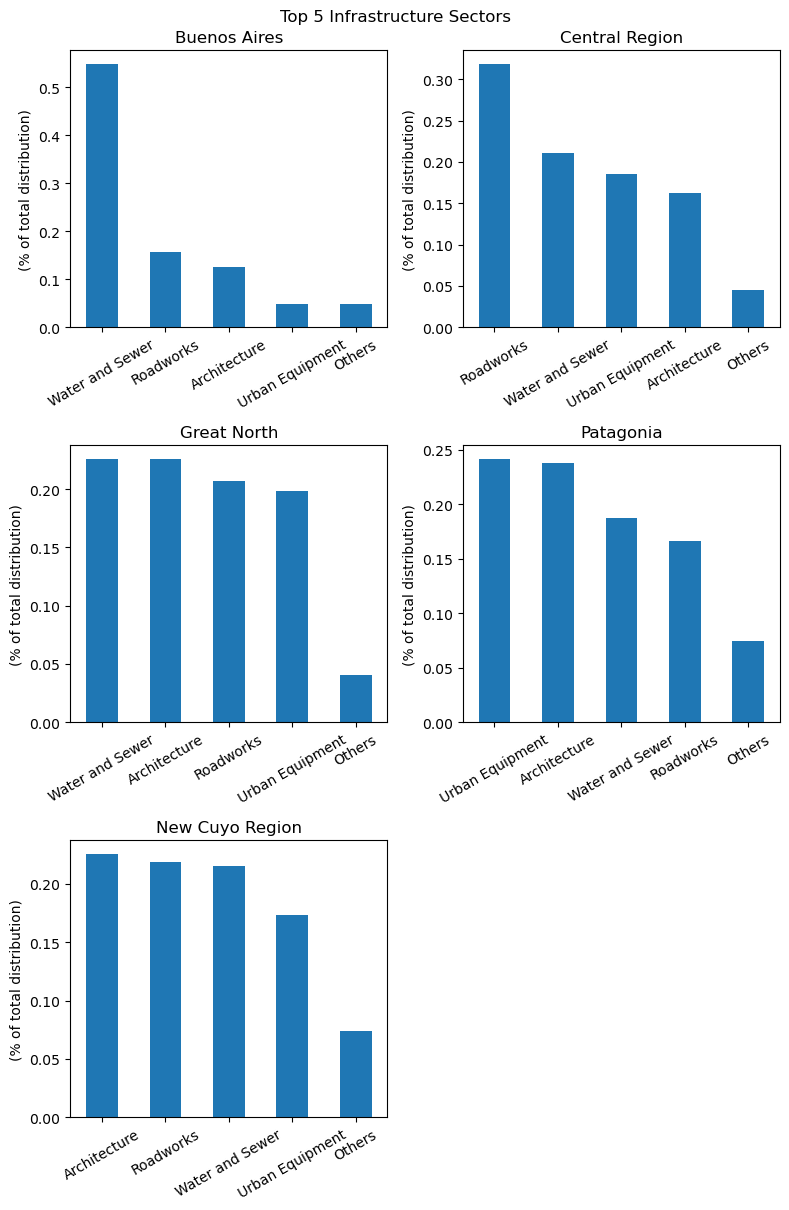

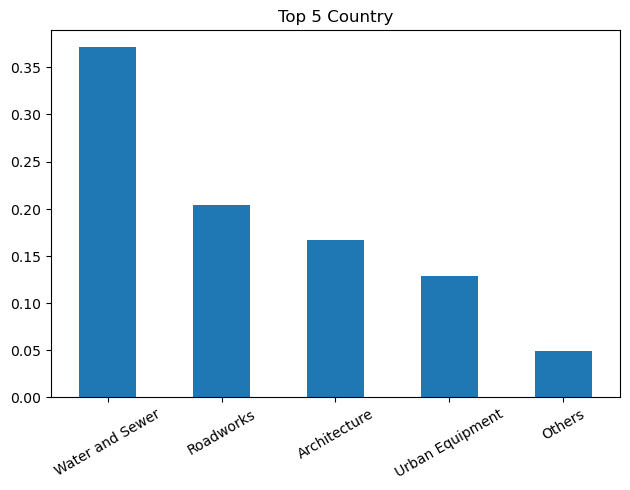

Type of Project Distribution (Country Level)
sector
Water and Sewer    0.371072
Roadworks          0.203473
Architecture       0.167025
Urban Equipment    0.128282
Others             0.049361
Healthcare         0.029703
Water resources    0.024250
Education          0.019658
Housing            0.007175
Name: proportion, dtype: float64


<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(8,12))
for i in range(len(regions)):

    ax = plt.subplot(3, 2, i+1)
    df[df["region"] == regions[i] ].sector.value_counts(normalize=True).head().plot(kind="bar")
    plt.xticks(rotation=30)
    plt.ylabel("(% of total distribution)")
    plt.xlabel("")
    plt.tight_layout()
    plt.title(f"{regions[i]}")

plt.subplots_adjust(hspace=0.7)
plt.tight_layout()
plt.suptitle("Top 5 Infrastructure Sectors", y=1.005)
plt.show()
plt.clf()

df.sector.value_counts(normalize=True).head().plot(kind="bar")
plt.xticks(rotation=30)
plt.xlabel("")
plt.tight_layout()
plt.title("Top 5 Country")
plt.show()
plt.clf()

print("Type of Project Distribution (Country Level)")
print(df.sector.value_counts(normalize=True))

### 3.Projects Statuses Analysis

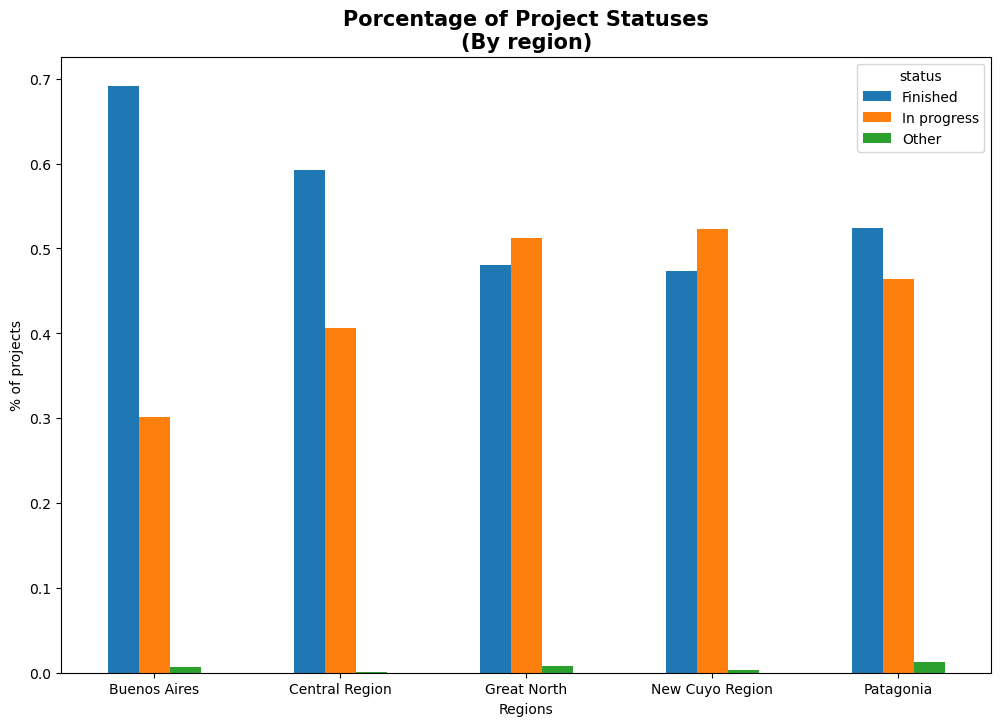

Project Statuses by Region
             region       status  proportion
0      Buenos Aires     Finished    0.691369
1      Buenos Aires  In progress    0.301616
2      Buenos Aires        Other    0.007014
3    Central Region     Finished    0.592006
4    Central Region  In progress    0.406616
5    Central Region        Other    0.001378
6       Great North  In progress    0.511932
7       Great North     Finished    0.480370
8       Great North        Other    0.007698
9   New Cuyo Region  In progress    0.522968
10  New Cuyo Region     Finished    0.473498
11  New Cuyo Region        Other    0.003534
12        Patagonia     Finished    0.523592
13        Patagonia  In progress    0.464231
14        Patagonia        Other    0.012177


<Figure size 640x480 with 0 Axes>

In [7]:
#Analysing the project statuses by each region
status_by_region = df.groupby("region").status.value_counts().reset_index()
status_by_region_norm = df.groupby("region").status.value_counts(normalize=True).reset_index()
status_by_region_pivot = status_by_region_norm.pivot(columns="status", index="region", values="proportion")

status_by_region_pivot.plot(kind="bar", figsize=(12,8))
plt.xticks(rotation=0)
plt.ylabel("% of projects")
plt.xlabel("Regions")
plt.title("""Porcentage of Project Statuses
(By region)""", fontsize=15, fontweight="bold")
plt.show()
plt.clf()

print("Project Statuses by Region")
print(status_by_region_norm)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Architecture'),
  Text(1, 0, 'Education'),
  Text(2, 0, 'Healthcare'),
  Text(3, 0, 'Housing'),
  Text(4, 0, 'Others'),
  Text(5, 0, 'Roadworks'),
  Text(6, 0, 'Urban Equipment'),
  Text(7, 0, 'Water and Sewer'),
  Text(8, 0, 'Water resources')])

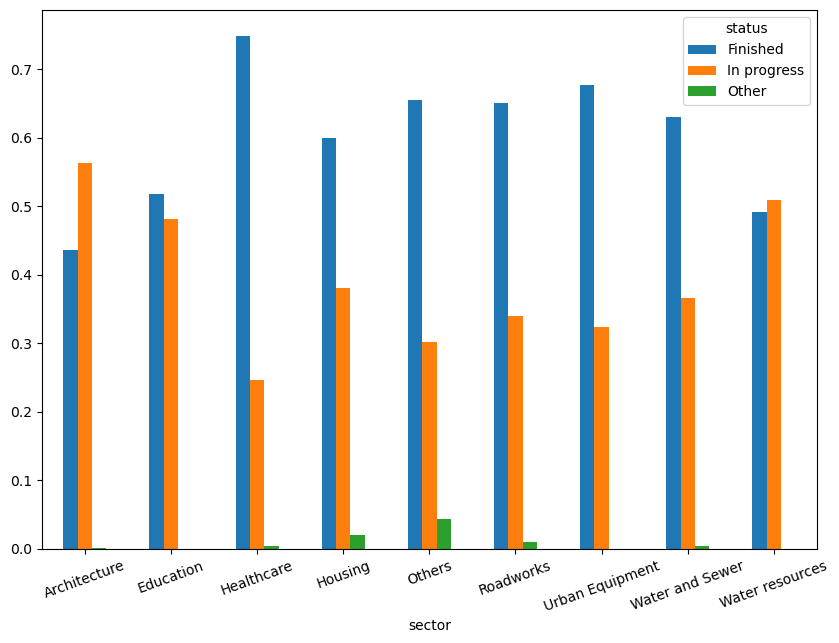

In [8]:
#Analysing the project statuses by each project type/sector
status_by_sector = df.groupby("sector").status.value_counts(normalize=True).reset_index()
status_by_sector_pivot = status_by_sector.pivot(columns="status", index="sector", values="proportion")

status_by_sector_pivot.plot(kind="bar", figsize=(10,7))
plt.xticks(rotation=20)

### 4. Projects Duration

In [9]:
### Calculating the average project duration for each region and sector

#There are no registered Housing projects on New Cuyo Region, so there's no average value in the table
average_duration_region = pd.pivot_table(df,  values="duration_days", columns="sector", index="region", aggfunc="mean")

In [10]:
average_duration_region

sector,Architecture,Education,Healthcare,Housing,Others,Roadworks,Urban Equipment,Water and Sewer,Water resources
region,,,,,,,,,
Buenos Aires,317.342995,550.820896,369.425287,326.666667,299.000000,367.440777,183.893082,257.468663,757.712329
Central Region,297.995763,537.947368,240.533333,168.133333,352.287879,421.041037,209.996283,317.429508,725.424242
Great North,336.391156,507.428571,284.909091,107.142857,428.773585,632.371747,171.182171,416.979592,408.888889
New Cuyo Region,347.203125,579.692308,496.500000,NaN,363.333333,894.161290,180.428571,462.573770,1125.000000
Patagonia,306.551282,313.208333,332.095238,90.000000,447.653061,854.376147,234.704403,404.121951,488.733333


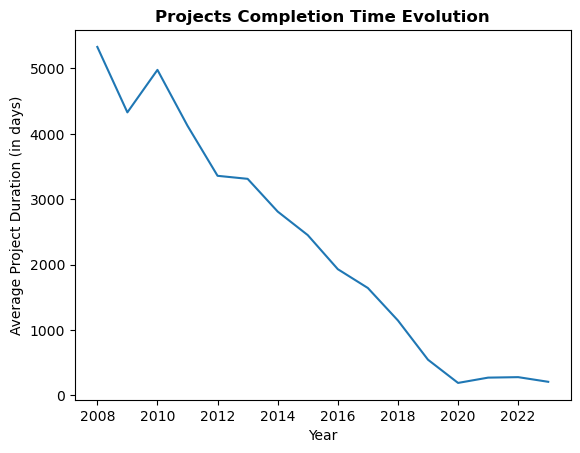

<Figure size 640x480 with 0 Axes>

In [11]:
duration_by_year = df.groupby("year_start")["duration_days"].mean().reset_index()

plt.plot(duration_by_year["year_start"], duration_by_year["duration_days"])
plt.xlabel("Year")
plt.ylabel("Average Project Duration (in days)")
plt.title("Projects Completion Time Evolution", fontweight="bold")
plt.show()
plt.clf()

In [12]:
df.head()

,project_id,year_start,year_finish,sector,total_amount,province,duration_days,status,region
0,1610,2019,2020,Water and Sewer,17872007.0,buenos aires,442,Finished,Buenos Aires
1,1613,2019,2021,Water and Sewer,7428947.0,buenos aires,470,Finished,Buenos Aires
2,1614,2019,2021,Water and Sewer,6390504.0,buenos aires,830,Finished,Buenos Aires
3,1615,2019,2021,Water and Sewer,11193140.0,buenos aires,690,Finished,Buenos Aires
4,1617,2022,2023,Water and Sewer,65554904.0,buenos aires,330,In progress,Buenos Aires
